In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import plotly
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier  # Cambio clave: Red Neuronal
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import fbeta_score, f1_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, auc, mean_squared_error, r2_score

from utils.data_loader import load_split, prepare_features_target
from utils.learning_curve import learning_curve_with_resampling
from models.manage_models import save_model

from sklearn.neural_network import MLPClassifier

/home/olivia3/Nueva carpeta/Machine-Learning-Project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [3]:
train_df = load_split('train', data_dir='dataset/splits')
X_train, y_train = prepare_features_target(train_df, target_col='Fault')

In [4]:
def objective(trial):
    sampling_strategy = trial.suggest_categorical("sampling", ["none", "smote", "under"])
    
    # ARQUITECTURA SIMPLIFICADA
    n_layers = trial.suggest_int("n_layers", 1, 2)  # Máximo 2 capas
    
    hidden_layer_sizes = []
    for i in range(n_layers):
        n_neurons = trial.suggest_categorical(f"neurons_layer_{i}", [32, 64, 128])  # Opciones reducidas
        hidden_layer_sizes.append(n_neurons)
    
    hidden_layer_sizes = tuple(hidden_layer_sizes)
    
    # PARÁMETROS BÁSICOS
    activation = trial.suggest_categorical("activation", ["relu"])  # Solo relu (más rápida)
    solver = trial.suggest_categorical("solver", ["adam"])  
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 0.001, 0.01, log=True)
    
    # MENOS ITERACIONES
    max_iter = trial.suggest_int("max_iter", 100, 300)
    
    # CONFIGURACIÓN RÁPIDA
    steps = [('scaler', StandardScaler())]
    
    if sampling_strategy == "smote":
        steps.append(('resample', SMOTE(random_state=42)))
    elif sampling_strategy == "under":
        steps.append(('resample', RandomUnderSampler(random_state=42)))
    
    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        early_stopping=True,  # Siempre activo para parar temprano
        validation_fraction=0.1,
        random_state=42,
        verbose=False
    )
    steps.append(('clf', clf))
    
    pipeline = ImbPipeline(steps)
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3 folds en lugar de 5
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=f2_scorer, n_jobs=-1)
    
    return scores.mean()

In [5]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, n_jobs=-1) 

print(f"Mejor score (f2_scorer): {study.best_value:.4f}")
print(f"Mejores parámetros: {study.best_params}")

[I 2026-01-03 21:49:26,140] A new study created in memory with name: no-name-ea020894-ce66-4d51-9ed6-129dd48a43f0
[I 2026-01-03 21:49:36,344] Trial 5 finished with value: 0.8010595448286656 and parameters: {'sampling': 'none', 'n_layers': 2, 'neurons_layer_0': 32, 'neurons_layer_1': 64, 'activation': 'relu', 'solver': 'adam', 'alpha': 2.0462160658395175e-05, 'learning_rate_init': 0.007173637326274062, 'max_iter': 165}. Best is trial 5 with value: 0.8010595448286656.
[I 2026-01-03 21:49:47,728] Trial 7 finished with value: 0.8096798038661502 and parameters: {'sampling': 'none', 'n_layers': 2, 'neurons_layer_0': 128, 'neurons_layer_1': 64, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00015065925469550623, 'learning_rate_init': 0.004290418122157452, 'max_iter': 265}. Best is trial 7 with value: 0.8096798038661502.
[I 2026-01-03 21:50:00,750] Trial 3 finished with value: 0.8647328229886752 and parameters: {'sampling': 'smote', 'n_layers': 2, 'neurons_layer_0': 64, 'neurons_layer_1': 

Mejor score (f2_scorer): 0.8684
Mejores parámetros: {'sampling': 'smote', 'n_layers': 2, 'neurons_layer_0': 32, 'neurons_layer_1': 128, 'activation': 'relu', 'solver': 'adam', 'alpha': 1.249277944635867e-05, 'learning_rate_init': 0.00851024154160005, 'max_iter': 148}


In [6]:
df = study.trials_dataframe()

In [7]:
print("="*70)
print("ANÁLISIS COMPLETO DE RESULTADOS OPTUNA")
print("="*70)

# 1. Verificar columnas disponibles
print("Columnas disponibles en el DataFrame:")
print(df.columns.tolist())

# 2. Función CORREGIDA sin dependencia de pandas global
def extract_architecture(row):
    """Extrae la arquitectura de manera segura y robusta."""
    import numpy as np
    
    try:
        # Verificar si existe n_layers
        if 'params_n_layers' in row.index:
            n_layers_val = row['params_n_layers']
            if pd.isna(n_layers_val):
                n_layers = 1
            else:
                n_layers = int(float(n_layers_val))
        else:
            n_layers = 1
        
        # Recolectar neuronas
        neurons = []
        for i in range(n_layers):
            col_name = f'params_neurons_layer_{i}'
            if col_name in row.index:
                val = row[col_name]
                if not pd.isna(val):
                    neurons.append(str(int(float(val))))
        
        # Si no encontramos neuronas, buscar en cualquier columna neurons_layer
        if not neurons:
            for col in row.index:
                if 'neurons_layer' in str(col):
                    val = row[col]
                    if not pd.isna(val):
                        neurons.append(str(int(float(val))))
        
        return '-'.join(neurons) if neurons else '1-64'
    except Exception as e:
        return 'unknown'

# 3. Aplicar función
df['architecture'] = df.apply(extract_architecture, axis=1)

# 4. Asegurar otras columnas
if 'params_sampling' in df.columns:
    df['sampling'] = df['params_sampling'].fillna('none')
if 'params_activation' in df.columns:
    df['activation'] = df['params_activation'].fillna('relu')
if 'params_solver' in df.columns:
    df['solver'] = df['params_solver'].fillna('adam')

# 5. Mostrar resultados MEJORADOS
print("\nRESUMEN DE ARQUITECTURAS ENCONTRADAS:")
print(df['architecture'].value_counts())

print("\nPRIMERAS 10 FILAS CON ARQUITECTURA REAL:")
cols_to_show = ['value', 'architecture', 'sampling', 'activation', 'solver']
print(df[cols_to_show].head(10))

# 6. Análisis adicional: verificar parámetros nulos
print("\nVERIFICACION DE PARAMETROS NULOS:")
null_counts = {}
for col in df.columns:
    if col.startswith('params_'):
        null_count = df[col].isna().sum()
        if null_count > 0:
            null_counts[col] = null_count

if null_counts:
    print("Columnas con valores nulos:")
    for col, count in null_counts.items():
        print(f"  {col}: {count} nulos")
else:
    print("No hay valores nulos en los parámetros.")

ANÁLISIS COMPLETO DE RESULTADOS OPTUNA
Columnas disponibles en el DataFrame:
['number', 'value', 'datetime_start', 'datetime_complete', 'duration', 'params_activation', 'params_alpha', 'params_learning_rate_init', 'params_max_iter', 'params_n_layers', 'params_neurons_layer_0', 'params_neurons_layer_1', 'params_sampling', 'params_solver', 'state']

RESUMEN DE ARQUITECTURAS ENCONTRADAS:
architecture
128-64    3
32-128    3
128       3
32        2
32-64     2
64        2
128-32    2
64-32     1
64-64     1
32-32     1
Name: count, dtype: int64

PRIMERAS 10 FILAS CON ARQUITECTURA REAL:
      value architecture sampling activation solver
0  0.856109       128-64    smote       relu   adam
1  0.797490           32     none       relu   adam
2  0.791911           64     none       relu   adam
3  0.864733        64-32    smote       relu   adam
4  0.862201           64    under       relu   adam
5  0.801060        32-64     none       relu   adam
6  0.868446       32-128    smote       relu   

In [8]:
print("\n" + "="*70)
print("ESTADISTICAS DETALLADAS")
print("="*70)

# Estadísticas básicas
print(f"Numero total de trials: {len(df)}")
print(f"Mejor F2-Score: {df['value'].max():.4f} (Trial {df['value'].idxmax()})")
print(f"Peor F2-Score: {df['value'].min():.4f}")
print(f"F2-Score promedio: {df['value'].mean():.4f}")
print(f"Desviacion estandar: {df['value'].std():.4f}")

# Distribución por sampling
print("\nDISTRIBUCION POR ESTRATEGIA DE SAMPLING:")
if 'sampling' in df.columns:
    sampling_counts = df['sampling'].value_counts()
    for strategy, count in sampling_counts.items():
        avg_score = df[df['sampling'] == strategy]['value'].mean()
        print(f"  {strategy:8s}: {count:2d} trials | Score promedio: {avg_score:.4f}")

# Análisis por arquitectura REAL 
print("\nTOP ARQUITECTURAS POR SCORE:")
if 'architecture' in df.columns and df['architecture'].nunique() > 1:
    # Filtrar solo arquitecturas conocidas (no 'unknown')
    known_arch = df[df['architecture'] != 'unknown'].copy()
    
    if len(known_arch) > 0:
        # Para cada arquitectura, obtener estadísticas
        arch_groups = []
        for arch in known_arch['architecture'].unique():
            arch_df = known_arch[known_arch['architecture'] == arch]
            arch_groups.append({
                'architecture': arch,
                'mean_score': arch_df['value'].mean(),
                'max_score': arch_df['value'].max(),
                'count': len(arch_df),
                'common_sampling': arch_df['sampling'].mode()[0] if len(arch_df['sampling'].mode()) > 0 else 'none'
            })
        
        # Convertir a DataFrame y ordenar
        arch_stats = pd.DataFrame(arch_groups)
        arch_stats = arch_stats.sort_values('mean_score', ascending=False)
        
        print("\nTop arquitecturas:")
        for idx, row in arch_stats.head(5).iterrows():
            print(f"  {row['architecture']:15s}: {row['mean_score']:.4f} | {row['count']} trials | {row['common_sampling']}")
    else:
        print("  No hay arquitecturas conocidas (todas son 'unknown')")
        
        print("\nIntentando reconstruir arquitecturas desde parámetros...")
        
        # Crear arquitectura manualmente
        def manual_architecture(row):
            if 'params_n_layers' in row:
                n_layers = int(row['params_n_layers']) if not pd.isna(row['params_n_layers']) else 1
                neurons = []
                for i in range(n_layers):
                    key = f'params_neurons_layer_{i}'
                    if key in row and not pd.isna(row[key]):
                        neurons.append(str(int(row[key])))
                return '-'.join(neurons) if neurons else '1-64'
            return '1-64'
        
        df['manual_architecture'] = df.apply(manual_architecture, axis=1)
        print("Arquitecturas reconstruidas:")
        print(df['manual_architecture'].value_counts().head())
else:
    print("  No se pudieron extraer arquitecturas válidas")

# Análisis por número de capas
print("\nANALISIS POR NUMERO DE CAPAS:")
if 'params_n_layers' in df.columns:
    # Rellenar nulos con 1
    df['n_layers_filled'] = df['params_n_layers'].fillna(1)
    layer_stats = df.groupby('n_layers_filled')['value'].agg(['mean', 'max', 'count'])
    for layers, row in layer_stats.iterrows():
        layers_int = int(layers)
        print(f"  {layers_int} capas: Score promedio {row['mean']:.4f} | {int(row['count'])} trials")


ESTADISTICAS DETALLADAS
Numero total de trials: 20
Mejor F2-Score: 0.8684 (Trial 6)
Peor F2-Score: 0.7919
F2-Score promedio: 0.8470
Desviacion estandar: 0.0284

DISTRIBUCION POR ESTRATEGIA DE SAMPLING:
  smote   :  9 trials | Score promedio: 0.8631
  under   :  6 trials | Score promedio: 0.8624
  none    :  5 trials | Score promedio: 0.7997

TOP ARQUITECTURAS POR SCORE:

Top arquitecturas:
  128            : 0.8666 | 3 trials | smote
  128-32         : 0.8649 | 2 trials | smote
  64-32          : 0.8647 | 1 trials | smote
  32-128         : 0.8633 | 3 trials | smote
  32-32          : 0.8615 | 1 trials | under

ANALISIS POR NUMERO DE CAPAS:
  1 capas: Score promedio 0.8446 | 7 trials
  2 capas: Score promedio 0.8483 | 13 trials


In [9]:
optuna.visualization.plot_optimization_history(study)


IMPORTANCIA REAL DE HIPERPARÁMETROS
Importancia calculada por Optuna (de mayor a menor):
  sampling                 : 0.9111
  max_iter                 : 0.0628
  learning_rate_init       : 0.0189
  neurons_layer_0          : 0.0049
  alpha                    : 0.0013
  n_layers                 : 0.0009
  solver                   : 0.0000
  activation               : 0.0000


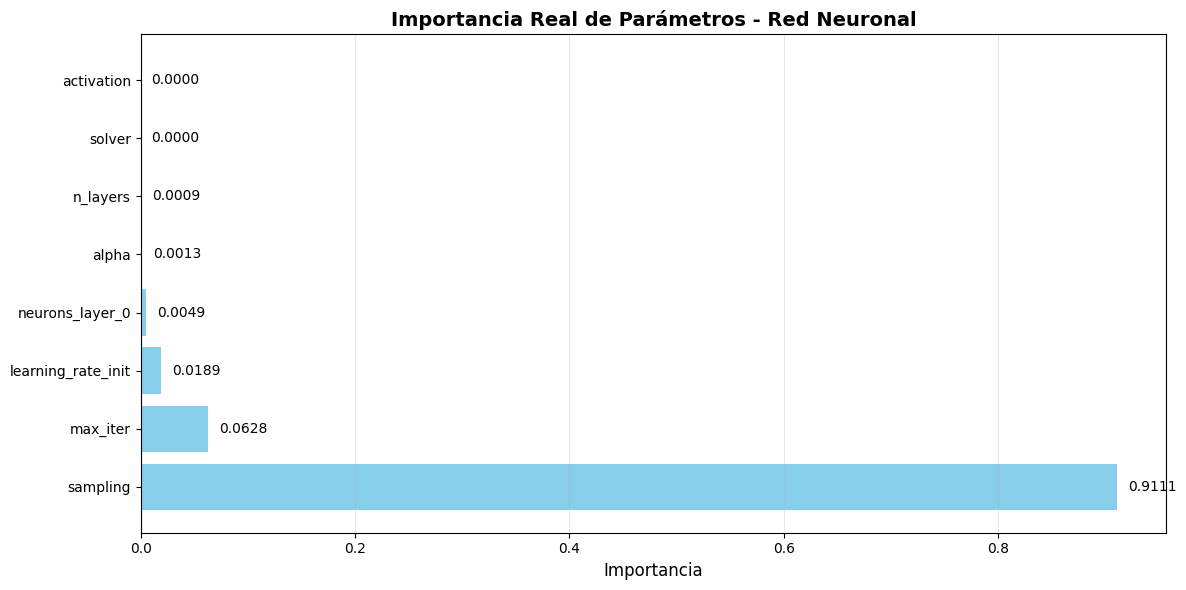

In [10]:
print("\n" + "="*70)
print("IMPORTANCIA REAL DE HIPERPARÁMETROS")
print("="*70)

# Método 1: Usar la función de importancia de Optuna con más detalle
try:
    importances = optuna.importance.get_param_importances(study, target=lambda t: t.value)
    
    print("Importancia calculada por Optuna (de mayor a menor):")
    for param, importance in sorted(importances.items(), key=lambda x: x[1], reverse=True):
        print(f"  {param:25s}: {importance:.4f}")
    
    # Gráfico MEJORADO
    fig, ax = plt.subplots(figsize=(12, 6))
    params = list(importances.keys())
    values = list(importances.values())
    
    bars = ax.barh(params, values, color='skyblue')
    ax.set_xlabel('Importancia', fontsize=12)
    ax.set_title('Importancia Real de Parámetros - Red Neuronal', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Añadir valores
    for bar, value in zip(bars, values):
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{value:.4f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"No se pudo calcular importancia: {e}")
    
    # Método alternativo: Calcular correlación manual
    print("\n Calculando importancia mediante correlación:")
    numeric_params = []
    for col in df.columns:
        if col.startswith('params_') and col not in ['params_sampling', 'params_activation', 'params_solver']:
            if df[col].dtype in ['int64', 'float64']:
                numeric_params.append(col)
    
    correlations = {}
    for param in numeric_params:
        corr = df[param].corr(df['value'])
        if not pd.isna(corr):
            correlations[param.replace('params_', '')] = abs(corr)
    
    # Mostrar top 10
    print("Top parámetros por correlación absoluta con el score:")
    for param, corr in sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {param:25s}: {corr:.4f}")

In [11]:

print("\n" + "="*70)
print("GRÁFICOS DE CONTORNO Y RELACIONES")
print("="*70)

# alpha vs learning_rate_init (parámetros clave)
print("Regularización (alpha) vs Tasa de Aprendizaje")
try:
    fig1 = optuna.visualization.plot_contour(
        study, 
        params=["alpha", "learning_rate_init"],
        target_name="F2-Score"
    )
    fig1.show()
except Exception as e:
    print(f" Error en gráfico 1: {e}")

# n_layers vs neurons de primera capa
print("\n Número de Capas vs Neuronas Primera Capa")
try:
    fig2 = optuna.visualization.plot_contour(
        study, 
        params=["n_layers", "neurons_layer_0"],
        target_name="F2-Score"
    )
    fig2.show()
except Exception as e:
    print(f" Error en gráfico 2: {e}")
    print("  Probando con max_iter vs neurons_layer_0...")
    try:
        fig2b = optuna.visualization.plot_contour(
            study, 
            params=["max_iter", "neurons_layer_0"],
            target_name="F2-Score"
        )
        fig2b.show()
    except Exception as e2:
        print(f"  También falló: {e2}")



GRÁFICOS DE CONTORNO Y RELACIONES
Regularización (alpha) vs Tasa de Aprendizaje



 Número de Capas vs Neuronas Primera Capa
